<a href="https://colab.research.google.com/github/Harji008/Neo4j_Twitter_Recommendation/blob/main/tsdb4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-53-5418917b9d26>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['date'] = pd.to_datetime(stock_data['date'])


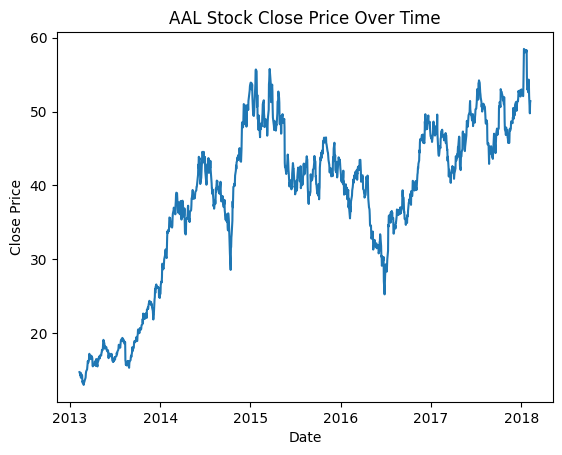

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [53]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('all_stocks_5yr.csv')

# Filter data for the stock 'AAL'
stock_data = data[data['Name'] == 'AAL']

# Convert 'date' column to datetime
stock_data['date'] = pd.to_datetime(stock_data['date'])

# Sort by date
stock_data = stock_data.sort_values(by='date')

# Plot the closing prices
plt.plot(stock_data['date'], stock_data['close'])
plt.title('AAL Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# Display first few rows
stock_data.head()


In [54]:
import numpy as np

# Calculate RSI
def calculate_rsi(data, window=14):
    delta = data.diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

stock_data['RSI'] = calculate_rsi(stock_data['close'])
stock_data.head()


,date,open,high,low,close,volume,Name,RSI
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,NaN
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,NaN
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,NaN
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,NaN
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,NaN


In [55]:
from sklearn.preprocessing import MinMaxScaler

# Scale the 'close' prices
scaler = MinMaxScaler()
stock_data['scaled_close'] = scaler.fit_transform(stock_data[['close']])

# Save the prepared dataset
stock_data.to_csv('aal_prepared_data.csv', index=False)


In [56]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Prepare the data for LSTM
sequence_length = 14
X, y = [], []
data = stock_data['scaled_close'].values
for i in range(sequence_length, len(data)):
    X.append(data[i-sequence_length:i])
    y.append(data[i])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Predict closing price
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=10, batch_size=32)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.1610
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0044
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0019
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0019
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0019
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0021
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0017


In [57]:
# Predict the next value
predicted = model.predict(X[-1].reshape(1, X.shape[1], 1))
predicted_price = scaler.inverse_transform(predicted)
print(f"Predicted closing price: {predicted_price[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
Predicted closing price: 52.16501235961914


In [58]:
model.save('lstm_model.h5')


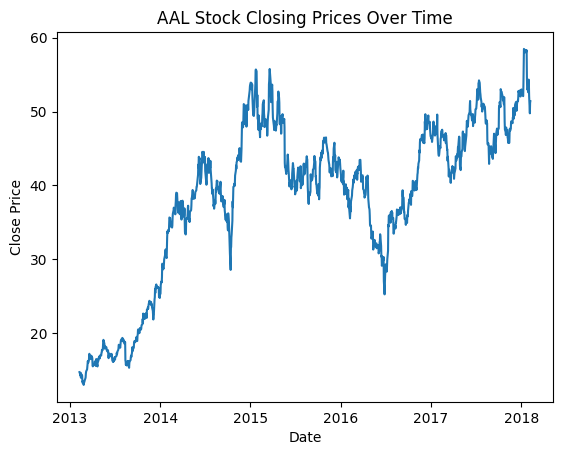

In [59]:
import matplotlib.pyplot as plt

# Plot the closing prices
plt.plot(stock_data['date'], stock_data['close'])
plt.title('AAL Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


In [60]:
# Generate statistical summaries
print(stock_data[['close', 'volume']].describe())



             close        volume
count  1259.000000  1.259000e+03
mean     38.393252  9.390321e+06
std      10.957636  6.899305e+06
min      13.020000  1.352400e+06
25%      34.330000  5.696393e+06
50%      40.870000  8.111323e+06
75%      46.535000  1.118854e+07
max      58.470000  1.377672e+08


In [61]:
import numpy as np

def calculate_rsi(data, window=14):
    delta = data.diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

stock_data['RSI'] = calculate_rsi(stock_data['close'])
print(stock_data[['date', 'close', 'RSI']].head(20))  # View the new RSI column


         date  close        RSI
0  2013-02-08  14.75        NaN
1  2013-02-11  14.46        NaN
2  2013-02-12  14.27        NaN
3  2013-02-13  14.66        NaN
4  2013-02-14  13.99        NaN
5  2013-02-15  14.50        NaN
6  2013-02-19  14.26        NaN
7  2013-02-20  13.33        NaN
8  2013-02-21  13.37        NaN
9  2013-02-22  13.57        NaN
10 2013-02-25  13.02        NaN
11 2013-02-26  13.26        NaN
12 2013-02-27  13.41        NaN
13 2013-02-28  13.43  35.067873
14 2013-03-01  13.61  37.608696
15 2013-03-04  13.90  43.913043
16 2013-03-05  14.05  47.587719
17 2013-03-06  14.57  49.040512
18 2013-03-07  14.82  59.718970
19 2013-03-08  14.92  55.440415


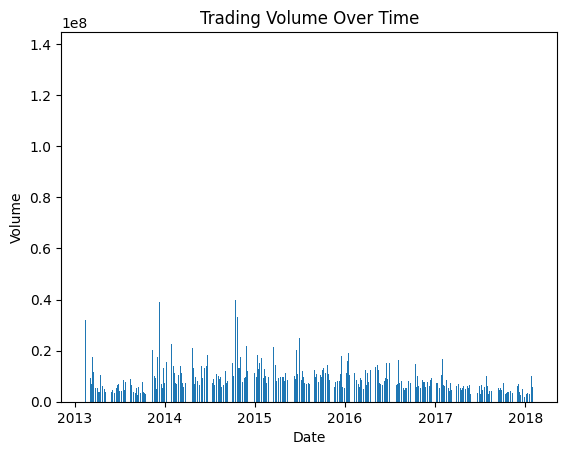

In [62]:
# Plot volume trends
plt.bar(stock_data['date'], stock_data['volume'])
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()


In [63]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Apply scaling to 'close' and 'RSI'
stock_data['scaled_close'] = scaler.fit_transform(stock_data[['close']])
stock_data['scaled_RSI'] = scaler.fit_transform(stock_data[['RSI']])


In [64]:
stock_data.head()

,date,open,high,low,close,volume,Name,RSI,scaled_close,scaled_RSI
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,NaN,0.038064,NaN
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,NaN,0.031683,NaN
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,NaN,0.027503,NaN
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,NaN,0.036084,NaN
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,NaN,0.021342,NaN


In [65]:
# Drop rows with NaN in the RSI column
stock_data = stock_data.dropna(subset=['RSI'])

# Display the updated dataset
stock_data.head()


,date,open,high,low,close,volume,Name,RSI,scaled_close,scaled_RSI
13,2013-02-28,13.49,13.63,13.39,13.43,6143600,AAL,35.067873,0.009021,0.345332
14,2013-03-01,13.37,13.95,13.32,13.61,7376800,AAL,37.608696,0.012981,0.373664
15,2013-03-04,13.50,14.07,13.47,13.90,8174800,AAL,43.913043,0.019362,0.443962
16,2013-03-05,14.01,14.05,13.71,14.05,7676100,AAL,47.587719,0.022662,0.484937
17,2013-03-06,14.52,14.68,14.25,14.57,13243200,AAL,49.040512,0.034103,0.501137


In [67]:
# Define the split ratio
train_size = int(len(stock_data) * 0.8)

# Split the dataset
train_data = stock_data[:train_size]
test_data = stock_data[train_size:]


In [68]:
print("Training dataset size:", len(train_data))
print("Testing dataset size:", len(test_data))


Training dataset size: 996
Testing dataset size: 250


In [69]:
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)


In [70]:
train_data.head()

,date,open,high,low,close,volume,Name,RSI,scaled_close,scaled_RSI
13,2013-02-28,13.49,13.63,13.39,13.43,6143600,AAL,35.067873,0.009021,0.345332
14,2013-03-01,13.37,13.95,13.32,13.61,7376800,AAL,37.608696,0.012981,0.373664
15,2013-03-04,13.50,14.07,13.47,13.90,8174800,AAL,43.913043,0.019362,0.443962
16,2013-03-05,14.01,14.05,13.71,14.05,7676100,AAL,47.587719,0.022662,0.484937
17,2013-03-06,14.52,14.68,14.25,14.57,13243200,AAL,49.040512,0.034103,0.501137


In [72]:
import numpy as np

# Define the sequence length (14 historical days)
sequence_length = 14

# Prepare the training data
X_train, y_train = [], []
train_values = train_data['scaled_close'].values  # Use scaled close prices

for i in range(sequence_length, len(train_values)):
    X_train.append(train_values[i-sequence_length:i])  # Last 14 days
    y_train.append(train_values[i])  # Next day's price

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))


In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout for regularization
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Single output for the predicted price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.1128 - val_loss: 0.0114
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0102 - val_loss: 0.0026
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0065 - val_loss: 0.0022
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0048 - val_loss: 0.0019
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0045 - val_loss: 0.0018
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0036 - val_l

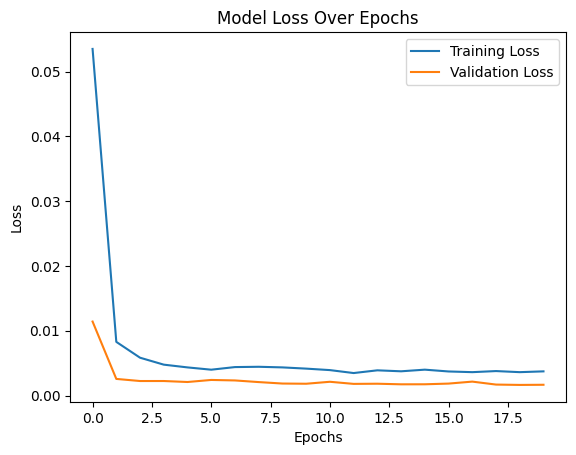

In [74]:
import matplotlib.pyplot as plt
# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


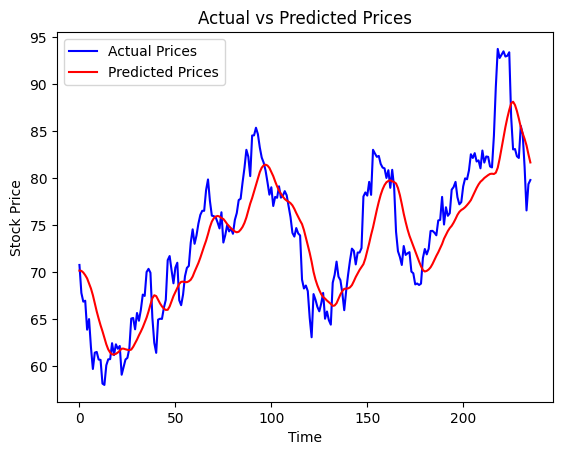

In [75]:
# Prepare the testing data
X_test, y_test = [], []
test_values = test_data['scaled_close'].values

for i in range(sequence_length, len(test_values)):
    X_test.append(test_values[i-sequence_length:i])
    y_test.append(test_values[i])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Predict on the testing data
predicted_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(predicted_scaled)  # Convert back to original scale
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted prices
plt.plot(actual, color='blue', label='Actual Prices')
plt.plot(predicted, color='red', label='Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [76]:
# Example for sequence_length = 30
sequence_length = 30

# Re-prepare training data with the new sequence length
X_train, y_train = [], []
train_values = train_data['scaled_close'].values

for i in range(sequence_length, len(train_values)):
    X_train.append(train_values[i-sequence_length:i])
    y_train.append(train_values[i])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Re-train the model with the new sequence length
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0785 - val_loss: 0.0037
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0081 - val_loss: 0.0028
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0056 - val_loss: 0.0025
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0052 - val_loss: 0.0023
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0055 - val_loss: 0.0036
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0054 - val_loss: 0.0026
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0051 - val_loss: 0.0028
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0047 - val_loss: 0.0019
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0045 - val_l

In [77]:
# Example with 100 LSTM units
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.0674 - val_loss: 0.0025
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.

In [78]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

# Function to prepare data dynamically based on sequence length
def prepare_data(sequence_length, dataset):
    X, y = [], []
    values = dataset['scaled_close'].values  # Use scaled_close column

    for i in range(sequence_length, len(values)):
        X.append(values[i-sequence_length:i])  # Last 'sequence_length' days
        y.append(values[i])  # Next day's price

    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM
    return X, y

# Function to build, train, and evaluate the model
def train_model(sequence_length, units, optimizer, batch_size, train_data, test_data):
    # Prepare training and testing data
    X_train, y_train = prepare_data(sequence_length, train_data)
    X_test, y_test = prepare_data(sequence_length, test_data)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))  # Dropout to prevent overfitting
    model.add(LSTM(units=units))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Predict one value (next day's price)

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_split=0.2, verbose=1)

    # Predict on test data
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)  # Convert back to original scale
    actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # Convert back to original scale

    # Calculate MAE and MSE
    mae = mean_absolute_error(actual, predictions)
    mse = mean_squared_error(actual, predictions)

    return model, history, mae, mse

# Define hyperparameter combinations
hyperparameters = [
    {'sequence_length': 7, 'units': 50, 'optimizer': Adam(), 'batch_size': 32},
    {'sequence_length': 14, 'units': 100, 'optimizer': Adam(), 'batch_size': 32},
    {'sequence_length': 30, 'units': 50, 'optimizer': RMSprop(), 'batch_size': 64},
    {'sequence_length': 14, 'units': 150, 'optimizer': RMSprop(), 'batch_size': 16},
]

# Track the best model
best_model = None
best_mae = float('inf')  # Start with a very high value
best_mse = float('inf')
best_params = None

# Perform hyperparameter tuning
for params in hyperparameters:
    print(f"Testing params: {params}")
    model, history, mae, mse = train_model(
        sequence_length=params['sequence_length'],
        units=params['units'],
        optimizer=params['optimizer'],
        batch_size=params['batch_size'],
        train_data=train_data,
        test_data=test_data
    )
    print(f"MAE: {mae}, MSE: {mse}")

    # Save the best model based on MAE
    if mae < best_mae:
        best_model = model
        best_mae = mae
        best_mse = mse
        best_params = params

# Save the best model
best_model.save('best_lstm_model.h5')

# Save the scaler as well (to transform data during predictions)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Output the best hyperparameters and performance
print(f"Best Model Saved!")
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")
print(f"Best MSE: {best_mse}")


Testing params: {'sequence_length': 7, 'units': 50, 'optimizer': <keras.src.optimizers.adam.Adam object at 0x7f67c71b0dc0>, 'batch_size': 32}
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1696 - val_loss: 0.0032
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0117 - val_loss: 0.0025
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0070 - val_loss: 0.0014
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0050 - val_loss: 0.0013
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0038 - val_loss: 0.0015
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0033 - val_loss: 0.0013
8/8 ━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1088 - val_loss: 0.0073
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0066 - val_loss: 0.0023
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0028 - val_loss: 0.0017
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
MAE: 3.279179121144686, MSE: 16.238768654477777
Testing params: {'sequence_length': 30, 'units': 50, 'optimizer': <keras.s

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.1160 - val_loss: 0.0077
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0143 - val_loss: 0.0143
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0098 - val_loss: 0.0477
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0184 - val_loss: 0.0126
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0091 - val_loss: 0.0203
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0112 - val_loss: 0.0187
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0095 - val_loss: 0.0068
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0080 - val_loss: 0.0071
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0069 - val_loss: 0.0022
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
MAE: 3.577450929400056, MSE: 19.184097894079752
Testing params: {'sequence_length': 14, 'units': 150, 'optimizer': <keras.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0462 - val_loss: 0.0063
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0087 - val_loss: 0.0041
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0083 - val_loss: 0.0239
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0049 - val_loss: 0.0077
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0045 - val_loss: 0.0061
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0036 - val_loss: 0.0565
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


MAE: 26.498321254077425, MSE: 717.9197726248117
Best Model Saved!
Best Parameters: {'sequence_length': 7, 'units': 50, 'optimizer': <keras.src.optimizers.adam.Adam object at 0x7f67c71b0dc0>, 'batch_size': 32}
Best MAE: 2.7346272264455647
Best MSE: 12.093797925672895


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


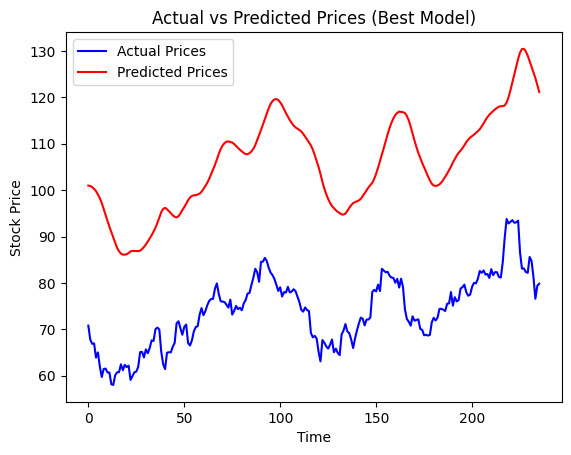

In [80]:
# Load the best model (optional, if you need to reload it)
from tensorflow.keras.models import load_model
best_model = load_model('best_lstm_model.h5')

# Prepare the test data
X_test, y_test = prepare_data(14, test_data)  # Using the best sequence_length
predictions = best_model.predict(X_test)

# Convert predictions and actual values back to original scale
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted prices
import matplotlib.pyplot as plt
plt.plot(actual, color='blue', label='Actual Prices')
plt.plot(predictions, color='red', label='Predicted Prices')
plt.title('Actual vs Predicted Prices (Best Model)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [81]:
if mae < best_mae:
    best_model = model
    best_mae = mae
    best_mse = mse
    best_params = params


In [82]:
# Save the best model
best_model.save('best_lstm_model.h5')

# Save the scaler for future use
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Best model and scaler have been saved.")


Best model and scaler have been saved.


In [83]:
from tensorflow.keras.models import load_model

# Load the saved model
best_model = load_model('best_lstm_model.h5')

# Prepare the test data
X_test, y_test = prepare_data(14, test_data)  # Use the best sequence_length

# Predict using the best model
predictions = best_model.predict(X_test)

# Convert predictions back to original scale
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(actual, predictions)
mse = mean_squared_error(actual, predictions)

print(f"Reloaded Model MAE: {mae}")
print(f"Reloaded Model MSE: {mse}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Reloaded Model MAE: 31.888924820651262
Reloaded Model MSE: 1048.476375791032


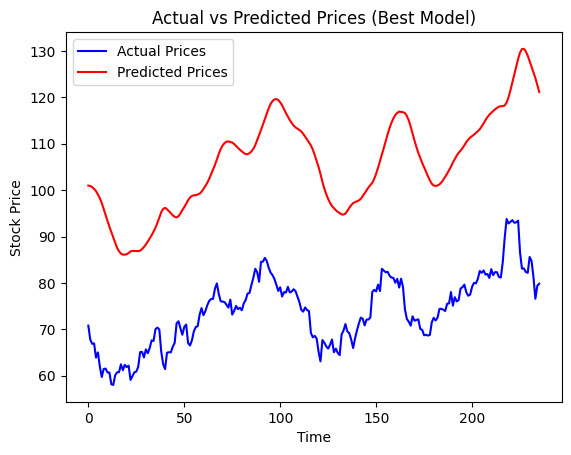

In [84]:
import matplotlib.pyplot as plt

plt.plot(actual, color='blue', label='Actual Prices')
plt.plot(predictions, color='red', label='Predicted Prices')
plt.title('Actual vs Predicted Prices (Best Model)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [85]:
!pip install streamlit pyngrok tensorflow scikit-learn pandas numpy


In [109]:
# Save the Streamlit app to a file
app_code = """
import streamlit as st
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import pickle

# Load the model and scaler
model = load_model('best_lstm_model.h5')
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Function to prepare data for prediction
def prepare_data(data, sequence_length):
    scaled_data = scaler.transform(data[['close', 'RSI']])
    X = []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
    return np.array(X)

# Streamlit App
st.title("Stock Price Prediction")
st.write("Upload stock data (CSV) and predict prices using a pre-trained LSTM model.")

# Upload file
uploaded_file = st.file_uploader("Upload a CSV file with historical stock prices", type=["csv"])

if uploaded_file:
    # Read the uploaded file
    data = pd.read_csv(uploaded_file)

    # Display uploaded data
    st.write("Uploaded Data Preview:")
    st.write(data.head())

    # Ensure the 'Close' column exists
    if 'Close' not in data.columns:
        st.error("The uploaded file must contain a 'Close' column.")
    else:
        # Get user input for sequence length
        sequence_length = st.slider("Select Sequence Length (Days)", 7, 30, value=14)

        # Prepare data for prediction
        values = data[['Close']].values
        X_input = prepare_data(values, sequence_length)

        # Predict using the model
        predictions = model.predict(X_input)
        predictions = scaler.inverse_transform(predictions)

        # Display predictions
        st.write("Predicted Stock Prices:")
        st.line_chart(predictions)

        # Download predictions
        predictions_df = pd.DataFrame(predictions, columns=["Predicted Prices"])
        csv = predictions_df.to_csv(index=False).encode('utf-8')
        st.download_button(
            label="Download Predictions as CSV",
            data=csv,
            file_name="predicted_prices.csv",
            mime="text/csv"
        )
"""

with open("app.py", "w") as f:
    f.write(app_code)


In [87]:
!ngrok authtoken 2p6TgmWdvkskmvn1BMAvVC6wFsb_5PhqmbRLjPRFBGayZ2Bsu

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [88]:
!pip install pyngrok


In [91]:
!ngrok http 8501


Traceback (most recent call last):
  File "/usr/lib/python3.10/subprocess.py", line 1209, in wait
    return self._wait(timeout=timeout)
  File "/usr/lib/python3.10/subprocess.py", line 1959, in _wait
    (pid, sts) = self._try_wait(0)
  File "/usr/lib/python3.10/subprocess.py", line 1917, in _try_wait
    (pid, sts) = os.waitpid(self.pid, wait_flags)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/ngrok", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/pyngrok/ngrok.py", line 582, in main
    run(sys.argv[1:])
  File "/usr/local/lib/python3.10/dist-packages/pyngrok/ngrok.py", line 570, in run
    process.run_process(pyngrok_config.ngrok_path, args)
  File "/usr/local/lib/python3.10/dist-packages/pyngrok/process.py", line 276, in run_process
    subprocess.call(start)
  File "/usr/lib/python3.10/subprocess.py", line 347, in call
    return p.wait(ti

In [92]:
!ngrok config add-authtoken 2p6Tgmlwdkvskmvn1BMAvVC6wFsb_5PhqmbRLjPRFBGay2ZBsu


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [93]:
!streamlit run app.py &





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.169.71.138:8501

  Stopping...


In [94]:
!streamlit run app.py &





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.169.71.138:8501

  Stopping...


In [96]:
import streamlit as st
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle

# Load the model and scaler
model = load_model('best_lstm_model.h5')
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Function to prepare input data
def prepare_input(data, sequence_length):
    scaled_data = scaler.transform(data)
    X = []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
    return np.array(X)

# Streamlit App
st.title("Stock Price Prediction")
st.write("""
This app predicts stock prices for a given historical dataset using a trained LSTM model.
""")

# File uploader
uploaded_file = st.file_uploader("Upload your CSV file with historical stock prices", type=["csv"])

if uploaded_file is not None:
    # Read uploaded file
    data = pd.read_csv(uploaded_file)

    # Display uploaded data
    st.subheader("Uploaded Data:")
    st.write(data.head())

    # Ensure 'Close' column exists
    if 'Close' not in data.columns:
        st.error("The uploaded file must contain a 'Close' column.")
    else:
        # Select the number of historical days
        sequence_length = st.slider("Select the number of historical days for prediction", 7, 30, 14)

        # Prepare data for prediction
        values = data[['Close']].values
        X_input = prepare_input(values, sequence_length)

        # Predict stock prices
        predictions = model.predict(X_input)
        predictions = scaler.inverse_transform(predictions)

        # Display predictions
        st.subheader("Predicted Stock Prices:")
        st.line_chart(predictions)

        # Allow user to download predictions
        predicted_df = pd.DataFrame(predictions, columns=["Predicted Prices"])
        csv = predicted_df.to_csv(index=False).encode('utf-8')
        st.download_button(
            label="Download Predictions as CSV",
            data=csv,
            file_name="predicted_prices.csv",
            mime="text/csv"
        )


2024-11-21 05:57:18.856 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-21 05:57:18.857 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-21 05:57:18.861 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-21 05:57:18.864 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-21 05:57:18.868 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-21 05:57:18.870 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-21 05:57:18.874 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-21 05:57:18.876 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [98]:
!echo 'YOUR CODE ABOVE' > app.py



In [101]:
!npm install -g localtunnel



added 22 packages, and audited 23 packages in 2s

3 packages are looking for funding
  run `npm fund` for details

1 moderate severity vulnerability

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.


In [102]:
!streamlit run app.py &





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.169.71.138:8501

  Stopping...


In [106]:
!curl ifconfig.me


34.169.71.138

In [110]:
scaler = MinMaxScaler()
scaler.fit(train_data[['close', 'RSI']])  # Ensure these columns match


MinMaxScaler()

In [112]:
from google.colab import files

# Save model
model.save("best_lstm_model.h5")
files.download("best_lstm_model.h5")

# Save scaler
import pickle
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
files.download("scaler.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>